<a href="https://colab.research.google.com/github/creater-shikha/assignment-1/blob/main/language_Translation_from_German_to_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import string 
import re 
from numpy import array, argmax, random, take
import pandas as pd 
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed 
from keras.preprocessing.text import Tokenizer 
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing. sequence import pad_sequences 
from keras.models import load_model 
from keras import optimizers 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

imported necessary packages

reading file using function

In [2]:
# function to read raw text file 
def read_text(filename): 
# open the file 
    file = open(filename, mode='rt', encoding='utf-8') 
# read all text 
    text = file.read() 
    file.close() 
    return text

splitting text into english german pairs seperated by '\n' and then split these pairs into english sentences and german sentences

In [3]:
#split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

actual data contains over 150000 sentence pairs,to reduce training time of model we are going to use 25000 sentence pairs


In [6]:
deu_eng = deu_eng[:25000,:]

In [7]:
#lets take a look at our data
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Sloths eat leaves.', 'Faultiere fressen Blätter.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6362940 (Hybrid) & #6363057 (Pfirsichbaeumchen)'],
       ['Smell this flower.', 'Rieche mal an dieser Blume!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1862493 (CK) & #1863483 (Pfirsichbaeumchen)'],
       ['So where were you?', 'Wo wart ihr also?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1664988 (kerbear407) & #2480333 (Zaghawa)']],
      dtype='<U537')

Text to sequence conversion to feed our data in seq2seq model encoder decoder we will have to convert both input and output sentences into 'integer sequences' of fixed length. before that to visualise the length of the sentences ,we will capture length of all sentences in 2 seperate lists for english and german respectively

In [8]:
# empty lists 
eng_1 = [] 
deu_1 = [] 
# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
     eng_1.append(len(i.split()))
for i in deu_eng[:,1]: 
     deu_1.append(len(i.split()))

In [9]:
length_df = pd.DataFrame({'eng':eng_1,'deu':deu_1})

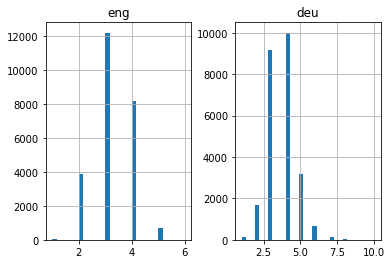

In [10]:
length_df.hist(bins = 30)
plt.show()

The maximum length of German sentences is 11 and that of the English phrases is 8 . so lets vectorize our text data using Keras's Tokenizer() class.It will turn our sentences into sequences of integers.then we will pad those integers with zeroes to make all sequences of same length

In [11]:
# function to build a tokenizer 
def tokenization(lines):
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(lines) 
    return tokenizer

In [12]:
# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[ :, 0])               
eng_vocab_size= len(eng_tokenizer.word_index) + 1 
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4144


In [13]:
# prepare deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[ :, 1])               
deu_vocab_size= len(deu_tokenizer.word_index) + 1 
deu_length = 8
print('deutch Vocabulary Size: %d' % deu_vocab_size)

deutch Vocabulary Size: 6556


function to prepare sequences,it will also perform sequence padding to maximum sentence length as mentioned above

In [14]:
# encode and pad sequences 
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences 
    seq = tokenizer.texts_to_sequences(lines) 
    # pad sequences with 0 values 
    seq = pad_sequences(seq, maxlen=length, padding='post') 
    return seq


**MODEL BUILDING**

we will now split the data into train and test set for model training and evaluation

In [15]:
from sklearn.model_selection import train_test_split 
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

Its time to encode sentences,we will encode german sentences as input sequences and english sentences as target sequences.it will be done for both train and test datasets

In [16]:
# prepare training data 
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1]) 
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [17]:
# prepare validation data 
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1]) 
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

**Most important part**

We are using an Embedding Layer and an LSTM layer as our encoder and another LSTM layer followed by a dense layer as decoder

In [18]:
# build NMT model 
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units): 
    model = Sequential() 
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True)) 
    model.add(Dense(out_vocab, activation='softmax')) 
    return model

We are using RMSprop optimizer for this model as it is very good for recurrent neural network(RNN)

In [28]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = tf.keras.optimizers.RMSprop(learning_rate=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

we have used 'sparse_categorical_crossentropy' as loss function because it allows us to use the target sequences as it is instead of one hot encoded format .One hot encoding the target sequences with such a huge vocabulary that it may consume whole system memory .We will train it for 30 epochs and with a batch size of 512.we will use ModelCheckPoint() to save the best model with lowest validation loss.this is best method over early stopping

In [30]:
filename = 'model.hl.28_shikha' 
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                     epochs=30, batch_size=512, 
                     validation_split = 0.2, 
                     callbacks=[checkpoint], verbose=1)

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 2.0572
Epoch 1: val_loss improved from inf to 2.18450, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 135s 4s/step - loss: 2.0572 - val_loss: 2.1845
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 1.9582
Epoch 2: val_loss improved from 2.18450 to 2.06028, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 123s 4s/step - loss: 1.9582 - val_loss: 2.0603
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 1.8759
Epoch 3: val_loss improved from 2.06028 to 2.01519, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 123s 4s/step - loss: 1.8759 - val_loss: 2.0152
Epoch 4/30
32/32 [==============================] - ETA: 0s - loss: 1.7977
Epoch 4: val_loss improved from 2.01519 to 1.96410, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 122s 4s/step - loss: 1.7977 - val_loss: 1.9641
Epoch 5/30
32/32 [==============================] - ETA: 0s - loss: 1.7266
Epoch 5: val_loss improved from 1.96410 to 1.91876, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 123s 4s/step - loss: 1.7266 - val_loss: 1.9188
Epoch 6/30
32/32 [==============================] - ETA: 0s - loss: 1.6570
Epoch 6: val_loss improved from 1.91876 to 1.89431, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 125s 4s/step - loss: 1.6570 - val_loss: 1.8943
Epoch 7/30
32/32 [==============================] - ETA: 0s - loss: 1.5912
Epoch 7: val_loss improved from 1.89431 to 1.82507, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 124s 4s/step - loss: 1.5912 - val_loss: 1.8251
Epoch 8/30
32/32 [==============================] - ETA: 0s - loss: 1.5217
Epoch 8: val_loss improved from 1.82507 to 1.80669, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 126s 4s/step - loss: 1.5217 - val_loss: 1.8067
Epoch 9/30
32/32 [==============================] - ETA: 0s - loss: 1.4619
Epoch 9: val_loss improved from 1.80669 to 1.76502, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 127s 4s/step - loss: 1.4619 - val_loss: 1.7650
Epoch 10/30
32/32 [==============================] - ETA: 0s - loss: 1.4025
Epoch 10: val_loss improved from 1.76502 to 1.74767, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 128s 4s/step - loss: 1.4025 - val_loss: 1.7477
Epoch 11/30
32/32 [==============================] - ETA: 0s - loss: 1.3454
Epoch 11: val_loss did not improve from 1.74767
32/32 [==============================] - 110s 3s/step - loss: 1.3454 - val_loss: 1.7503
Epoch 12/30
32/32 [==============================] - ETA: 0s - loss: 1.2881
Epoch 12: val_loss improved from 1.74767 to 1.67184, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 127s 4s/step - loss: 1.2881 - val_loss: 1.6718
Epoch 13/30
32/32 [==============================] - ETA: 0s - loss: 1.2367
Epoch 13: val_loss improved from 1.67184 to 1.64622, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 123s 4s/step - loss: 1.2367 - val_loss: 1.6462
Epoch 14/30
32/32 [==============================] - ETA: 0s - loss: 1.1807
Epoch 14: val_loss improved from 1.64622 to 1.60654, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 124s 4s/step - loss: 1.1807 - val_loss: 1.6065
Epoch 15/30
32/32 [==============================] - ETA: 0s - loss: 1.1341
Epoch 15: val_loss improved from 1.60654 to 1.58134, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 123s 4s/step - loss: 1.1341 - val_loss: 1.5813
Epoch 16/30
32/32 [==============================] - ETA: 0s - loss: 1.0837
Epoch 16: val_loss improved from 1.58134 to 1.55971, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 127s 4s/step - loss: 1.0837 - val_loss: 1.5597
Epoch 17/30
32/32 [==============================] - ETA: 0s - loss: 1.0351
Epoch 17: val_loss improved from 1.55971 to 1.54076, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 128s 4s/step - loss: 1.0351 - val_loss: 1.5408
Epoch 18/30
32/32 [==============================] - ETA: 0s - loss: 0.9880
Epoch 18: val_loss improved from 1.54076 to 1.52856, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 127s 4s/step - loss: 0.9880 - val_loss: 1.5286
Epoch 19/30
32/32 [==============================] - ETA: 0s - loss: 0.9439
Epoch 19: val_loss improved from 1.52856 to 1.50928, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 126s 4s/step - loss: 0.9439 - val_loss: 1.5093
Epoch 20/30
32/32 [==============================] - ETA: 0s - loss: 0.9001
Epoch 20: val_loss improved from 1.50928 to 1.48161, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 127s 4s/step - loss: 0.9001 - val_loss: 1.4816
Epoch 21/30
32/32 [==============================] - ETA: 0s - loss: 0.8537
Epoch 21: val_loss improved from 1.48161 to 1.46914, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 126s 4s/step - loss: 0.8537 - val_loss: 1.4691
Epoch 22/30
32/32 [==============================] - ETA: 0s - loss: 0.8136
Epoch 22: val_loss improved from 1.46914 to 1.45314, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 128s 4s/step - loss: 0.8136 - val_loss: 1.4531
Epoch 23/30
32/32 [==============================] - ETA: 0s - loss: 0.7744
Epoch 23: val_loss improved from 1.45314 to 1.43381, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 126s 4s/step - loss: 0.7744 - val_loss: 1.4338
Epoch 24/30
32/32 [==============================] - ETA: 0s - loss: 0.7339
Epoch 24: val_loss improved from 1.43381 to 1.42369, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 127s 4s/step - loss: 0.7339 - val_loss: 1.4237
Epoch 25/30
32/32 [==============================] - ETA: 0s - loss: 0.6957
Epoch 25: val_loss improved from 1.42369 to 1.41192, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 127s 4s/step - loss: 0.6957 - val_loss: 1.4119
Epoch 26/30
32/32 [==============================] - ETA: 0s - loss: 0.6562
Epoch 26: val_loss improved from 1.41192 to 1.39748, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 123s 4s/step - loss: 0.6562 - val_loss: 1.3975
Epoch 27/30
32/32 [==============================] - ETA: 0s - loss: 0.6229
Epoch 27: val_loss improved from 1.39748 to 1.38689, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 126s 4s/step - loss: 0.6229 - val_loss: 1.3869
Epoch 28/30
32/32 [==============================] - ETA: 0s - loss: 0.5857
Epoch 28: val_loss improved from 1.38689 to 1.38399, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 124s 4s/step - loss: 0.5857 - val_loss: 1.3840
Epoch 29/30
32/32 [==============================] - ETA: 0s - loss: 0.5540
Epoch 29: val_loss improved from 1.38399 to 1.37555, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 125s 4s/step - loss: 0.5540 - val_loss: 1.3755
Epoch 30/30
32/32 [==============================] - ETA: 0s - loss: 0.5208
Epoch 30: val_loss improved from 1.37555 to 1.36554, saving model to model.hl.28_shikha


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


INFO:tensorflow:Assets written to: model.hl.28_shikha/assets


32/32 [==============================] - 125s 4s/step - loss: 0.5208 - val_loss: 1.3655


lets compare the training loss and the validation loss

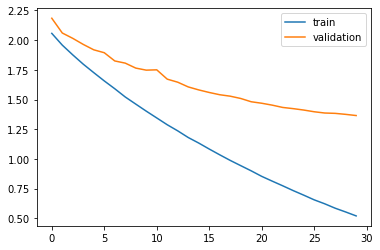

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.legend(['train', 'validation']) 
plt.show()

Lets load the saved model to make predictions

In [35]:
model = load_model('model.hl.28_shikha/')
preds = argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))), axis=-1) 

In [36]:
def get_word(n, tokenizer): 
    for word, index in tokenizer.word_index.items(): 
        if index == n: 
           return word
    return None

In [37]:
#convert predictions into text (English)
preds_text = [] 
for i in preds: 
    temp = [ ] 
    for j in range(len(i)): 
        t = get_word(i[j], eng_tokenizer) 
        if j > 0: 
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None): 
              temp.append(' ') 
            else:
              temp.append(t)
        else:
            if (t == None):
               temp.append(' ') 
            else: 
               temp.append(t) 
    preds_text.append(' '.join(temp))

In [38]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [39]:
pd.set_option('display.max_colwidth', 200)

checking first 15 sentences actual and predicted

In [40]:
pred_df.head(15)

,actual,predicted
0,I'm watching you.,i'm show you
1,Are we leaving?,we'll start
2,I didn't need Tom.,i don't knew tom
3,This is Tom.,this is tom
4,They're empty.,they're cold
5,Are you going?,are you going
6,I want a hat.,i need a coat
7,You keep it.,you keep it
8,Are you OK?,are you well ok
9,I called for help.,i saw tom for


checking last 15 sentences

In [41]:
pred_df.tail(15)

,actual,predicted
4985,Tom tricked me.,tom made me
4986,It's not too much.,it's not a
4987,Tom wept.,tom was
4988,Do you live there?,you them there
4989,Tom was baffled.,tom was anxious
4990,Go to bed.,go to sleep
4991,You can't lose.,you can't escape
4992,Who said that?,who did this
4993,He is very brave.,he is very angry
4994,It was so dark.,it was very cold


In [42]:
pred_df.head(100)

,actual,predicted
0,I'm watching you.,i'm show you
1,Are we leaving?,we'll start
2,I didn't need Tom.,i don't knew tom
3,This is Tom.,this is tom
4,They're empty.,they're cold
...,...,...
95,Do you work here?,you here
96,Even Tom laughed.,everybody tom cheated
97,I have no idea.,i have no clue
98,"Champagne, please.",please


100 rows × 2 columns